https://arxiv.org/pdf/1608.04667.pdf

In [ ]:
import numpy as np
import pandas as pd 
import os

In [ ]:
from keras.preprocessing import image

In [ ]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/kermany2018


import zipfile
zipref=zipfile.ZipFile("/content/kermany2018.zip",'r')
zipref.extractall()
zipref.close()

!rm -rf /content/kermany2018.zip

100% 10.8G/10.8G [01:36<00:00, 136MB/s]
100% 10.8G/10.8G [01:36<00:00, 121MB/s]


In [ ]:
import cv2
from skimage.restoration import estimate_sigma

#This function assumes the noise follows a Gaussian distribution. The estimation algorithm is based on the median absolute deviation of the wavelet 
def estimate_noise(image_path):
    img = cv2.imread(image_path)
    return estimate_sigma(img, multichannel=True, average_sigmas=True)  #Robust wavelet-based estimator of the (Gaussian) noise standard deviation.

In [ ]:
import random, os
path = r"/content/OCT2017 /train/NORMAL"
random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
print(random_filename)

estimate_noise('/content/OCT2017 /train/NORMAL/NORMAL-1001772-6.jpeg')

NORMAL-3114389-6.jpeg


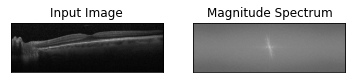

In [ ]:
im = '/content/OCT2017 /train/NORMAL/NORMAL-1001772-6.jpeg'

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(im,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

TypeError: ignored

hist_lines applicable only for grayscale images


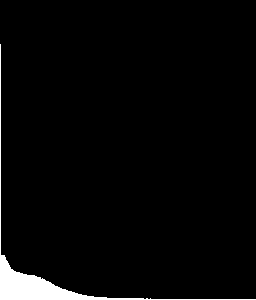

In [ ]:
from google.colab.patches import cv2_imshow


img = '/content/OCT2017 /train/NORMAL/NORMAL-1001772-6.jpeg'
h = np.zeros((300,256,3))
im = cv2.imread(img)
if len(im.shape)!=2:
    print("hist_lines applicable only for grayscale images")
    #print "so converting image to grayscale for representation"
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
hist_item = cv2.calcHist([im],[0],None,[256],[0,256])
cv2.normalize(hist_item,hist_item,0,255,cv2.NORM_MINMAX)
hist=np.int32(np.around(hist_item))
for x,y in enumerate(hist):
    x = int(x)
    y = int(y)
    cv2.line(h,(x,0),(x,y),(255,255,255))
y = np.flipud(h)
# y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
cv2_imshow(y)

In [ ]:
hist_lines('/content/OCT2017 /train/NORMAL/NORMAL-1001772-6.jpeg')

AttributeError: ignored

In [ ]:
train_images = sorted(os.listdir('/content/OCT2017 /train/NORMAL'))
train_images = train_images[:1000]
len(train_images)

NotADirectoryError: ignored

In [ ]:
train_image = []
for im in train_images:
    img = image.load_img('/content/OCT2017 /train/NORMAL/'+ im, target_size=(180,180), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

In [ ]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(180,180), cmap='gray')
    plt.show()

In [ ]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07   # Noise Value
    return noisy

In [ ]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [ ]:
noised_df= np.array(noised_df)

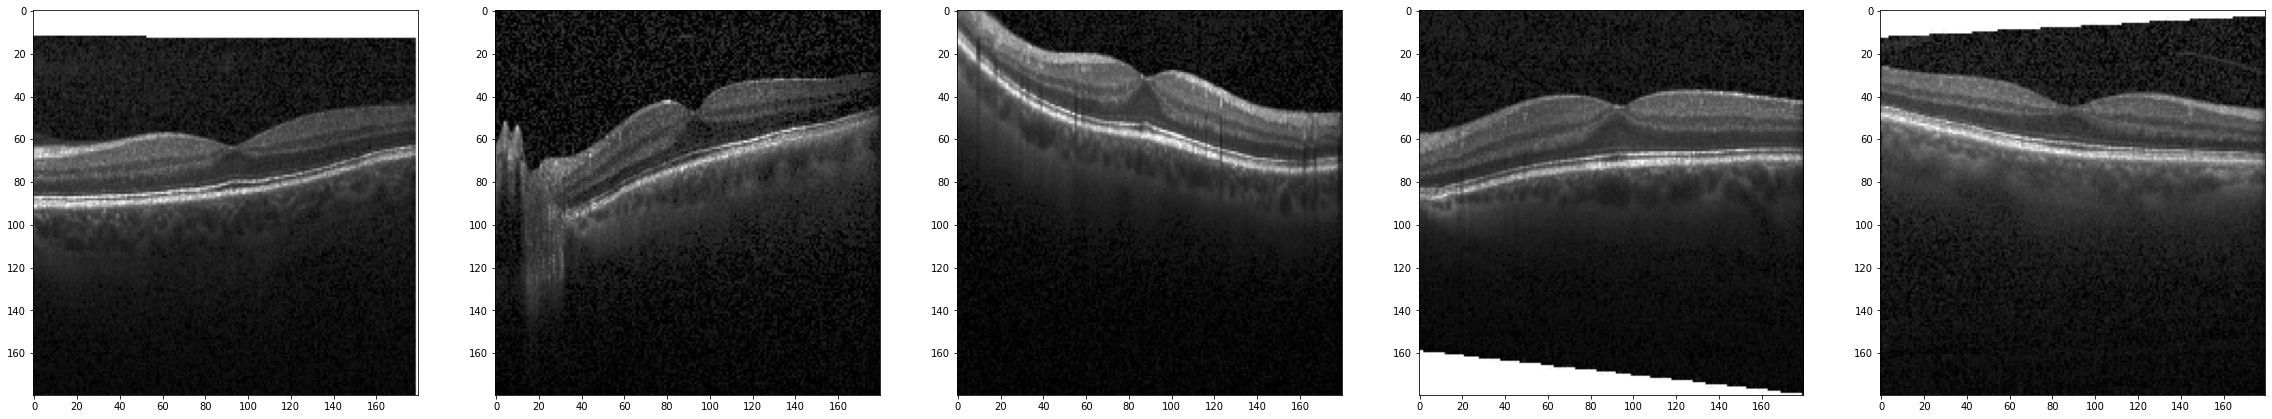

In [ ]:
show_img(train_df)

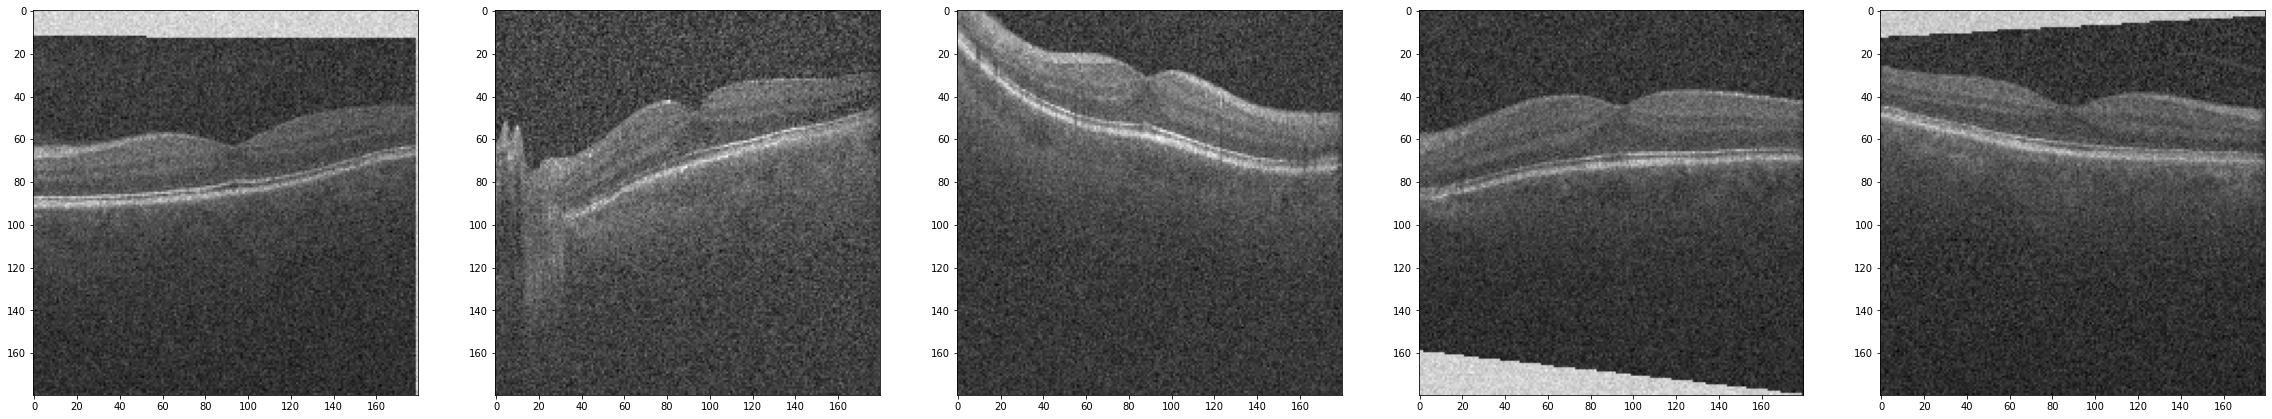

In [ ]:
show_img(noised_df)

In [ ]:
noised_df.shape

(1000, 180, 180, 1)

In [ ]:
train_df.shape

(1000, 180, 180, 1)

In [ ]:
xnoised= noised_df[0:100]
xtest= noised_df[100:]

In [ ]:
xnoised.shape

(100, 180, 180, 1)

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(180,180,1), name='image_input')
    
    #enoder 
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    
    #decoder
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(180, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [ ]:
model= autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 180, 180, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 180, 180, 180)     1800      
                                                                 
 pool1 (MaxPooling2D)        (None, 90, 90, 180)       0         
                                                                 
 Conv2 (Conv2D)              (None, 90, 90, 180)       291780    
                                                                 
 pool2 (MaxPooling2D)        (None, 45, 45, 180)       0         
                                                                 
 Conv3 (Conv2D)              (None, 45, 45, 180)       291780    
                                                                 
 upsample1 (UpSampling2D)    (None, 90, 90, 180)       0     

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model= autoencoder()
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 21s 751ms/step - loss: 0.6667 - val_loss: 0.5217
Epoch 2/40
10/10 [==============================] - 6s 682ms/step - loss: 0.4501 - val_loss: 0.3950
Epoch 3/40
10/10 [==============================] - 5s 498ms/step - loss: 0.4037 - val_loss: 0.3790
Epoch 4/40
10/10 [==============================] - 5s 497ms/step - loss: 0.3895 - val_loss: 0.3743
Epoch 5/40
10/10 [==============================] - 6s 683ms/step - loss: 0.3811 - val_loss: 0.3661
Epoch 6/40
10/10 [==============================] - 5s 514ms/step - loss: 0.3773 - val_loss: 0.3638
Epoch 7/40
10/10 [==============================] - 5s 505ms/step - loss: 0.3740 - val_loss: 0.3598
Epoch 8/40
10/10 [==============================] - 6s 685ms/step - loss: 0.3724 - val_loss: 0.3590
Epoch 9/40
10/10 [==============================] - 5s 509ms/step - loss: 0.3711 - val_loss: 0.3591
Epoch 10/40
10/10 [==============================] - 5s 512ms/step - loss: 0.3700 - val_loss: 0.356

In [ ]:
xtrain= train_df[100:]

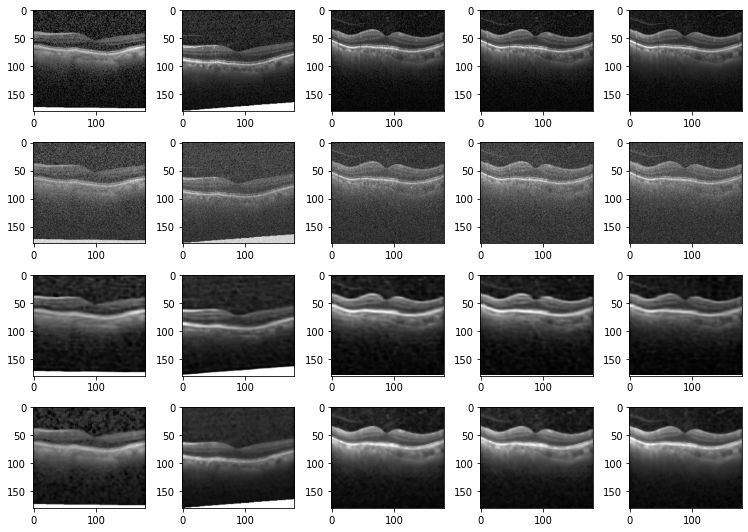

In [ ]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (180,180)), aspect='auto', cmap='gray') # Original image
        ax[1][i].imshow(np.reshape(y_true[i], (180,180)), aspect='auto', cmap='gray') # Noise Image
        ax[2][i].imshow(np.reshape(y_pred[i], (180,180)), aspect='auto', cmap='gray') # Denoised Image
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray') # Median Filter Image
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

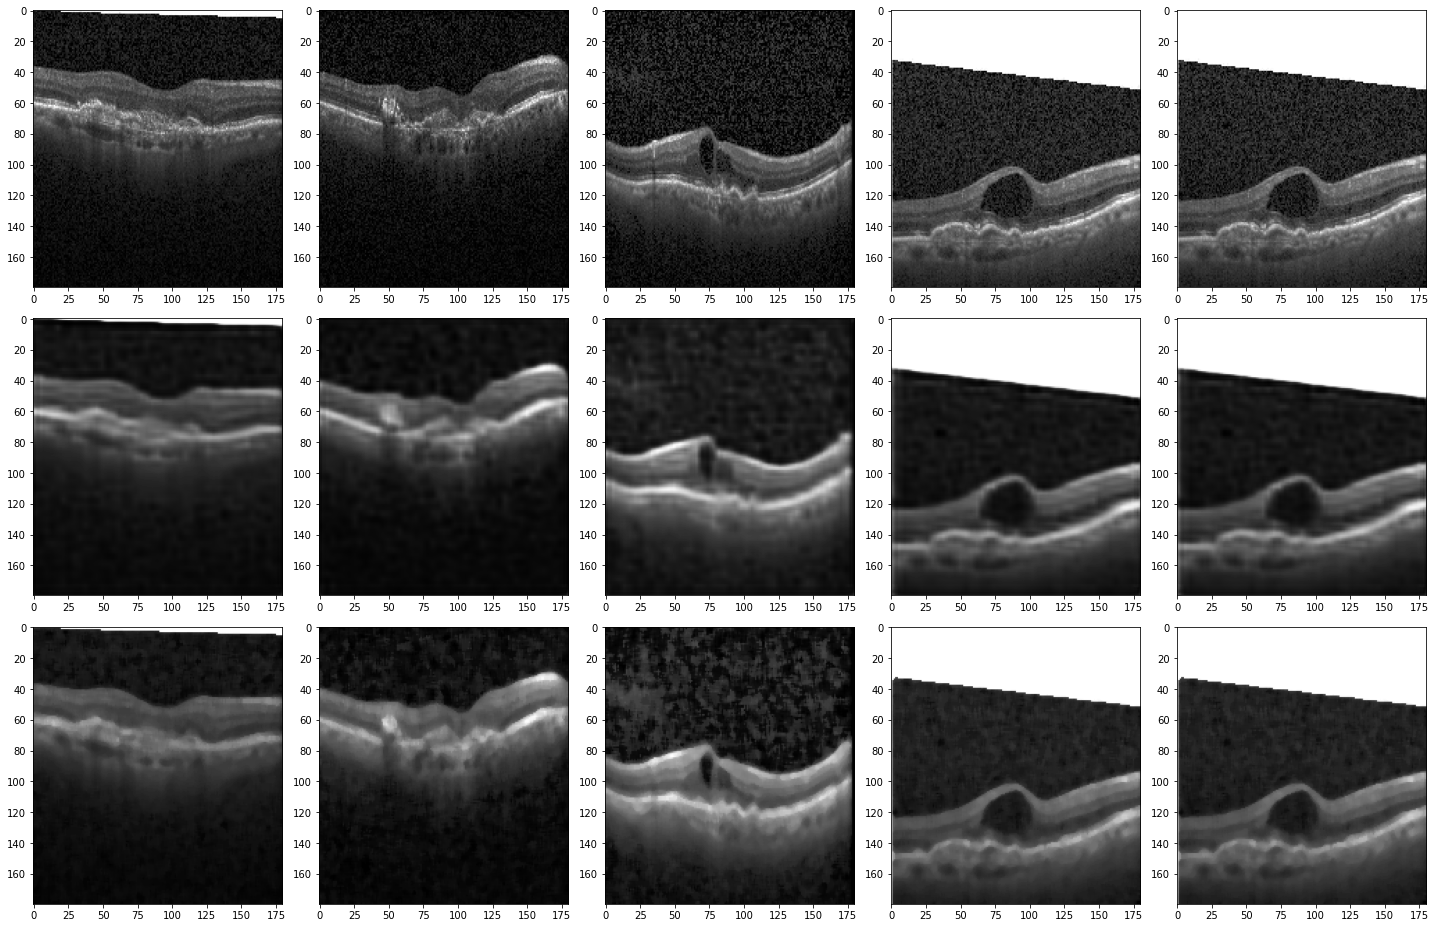

In [ ]:
val_images = sorted(os.listdir('/content/OCT2017 /train/CNV'))
val_images = val_images[:100]
val_image = []
for im in val_images:
    img = image.load_img('/content/OCT2017 /train/CNV/'+ im, target_size=(180,180), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
train_df = np.array(val_image)

import cv2

pred= model.predict(train_df[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(20,13)
    for i in range(5):
        ax[0][i].imshow(np.reshape(train_df[i], (180,180)), aspect='auto', cmap='gray')
        #ax[1][i].imshow(np.reshape(y_true[i], (180,180)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (180,180)), aspect='auto', cmap='gray')
        ax[2][i].imshow(cv2.medianBlur(train_df[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(train_df[:5], pred[:5])

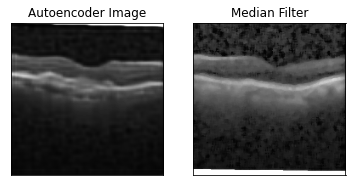

In [ ]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(180,180), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

SAR DATASET

In [ ]:
import os

com_wget = "sudo wget " +"https://github.com/prasmussen/gdrive/releases/download/2.1.1/gdrive_2.1.1_linux_386.tar.gz"
com_unzip = "sudo tar -xzf gdrive_2.1.1_linux_386.tar.gz"
com_permission = "sudo chmod +x gdrive"
com_install_executor = "sudo install gdrive /usr/local/bin/gdrive"

os.system(com_wget)
os.system(com_unzip)
os.system(com_permission)
os.system(com_install_executor)

0

In [ ]:
!sudo gdrive list

Authentication needed
Go to the following url in your browser:
https://accounts.google.com/o/oauth2/auth?access_type=offline&client_id=367116221053-7n0vf5akeru7on6o2fjinrecpdoe99eg.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=state

Enter verification code: 4/1ARtbsJr8ectv_kUAFijnZ7-dKNcJ7NKk6dEhaTcZknqaNuSke9HoTZTkPb4
Id                                  Name                    Type   Size      Created
10XzbooTnjys8yxcduTJpZaaDL6PbmLcb   slide3.xml              bin    2.2 KB    2022-02-10 08:02:09
1g1uruVRN_Cyg2gW_Zd7z9ZtlxdowfD7B   presentation.xml.rels   bin    4.7 KB    2022-02-10 08:02:15
10SIKJo-eOXyGcB7RWBIRoNf3eQrP8a32   image7.png              bin    15.4 KB   2022-02-10 08:01:54
1taMBfzvCb7trwKucsHKCn9fpi2fuI766   image9.png              bin    29.4 KB   2022-02-10 08:01:53
10lW8cXEKLpMVJgS0Y-O2B8zHQPAY5ppZ   slideLayout2.xml.rels   bin    311.0 B   2022-02-10 08:05:32

In [ ]:
!gdrive download 12GFYb613xKHWTd09ph2zBrZnauayOgBT

Downloaded 12GFYb613xKHWTd09ph2zBrZnauayOgBT at 15.7 MB/s, total 1.3 GB


In [ ]:
import zipfile
zipref=zipfile.ZipFile("/content/virtual_sar_training_set.zip",'r')
zipref.extractall()
zipref.close()

!rm -rf /content/virtual_sar_training_set.zip